## Grupo 7: Rubén Gómez y Adrián Sanjuán

# Índice
- [Carga de datos](#cargadedatos)
- [Modelo](#modelo)
  - [Creación del modelo](#creacion)
  - [Elección de arquitectura](#eleccion)
  - [Regularización](#reg)
  - [Métricas](#metricas)
  - [Evaluación del modelo](#eval)  
- [Conclusión](#conclusion)
- [Bibliografía](#bib)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
from pandas.io.parsers import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.datasets import make_blobs
from scipy import integrate
from sklearn.preprocessing import PolynomialFeatures
from numpy import arange, meshgrid, sqrt
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')
from tensorflow.keras.regularizers import L2
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from sklearn.metrics import f1_score
from keras import backend as K
import itertools
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a name="cargadedatos"></a>
# Carga de datos

In [ ]:
train = read_csv('/content/drive/MyDrive/AA/PFinal/train.csv', index_col= 0)
test = read_csv('/content/drive/MyDrive/AA/PFinal/test.csv', index_col= 0)
valid = read_csv('/content/drive/MyDrive/AA/PFinal/valid.csv',index_col= 0)

In [ ]:
X_train = train.drop(['is_promoted'], axis=1).values
y_train = train['is_promoted'].values
X_valid = valid.drop(['is_promoted'], axis=1).values
y_valid = valid['is_promoted'].values
X_test = test.drop(['is_promoted'], axis=1).values
y_test = test['is_promoted'].values


<a name="modelo"></a>
# Modelo
<a name="creacion"></a>
## Creación del modelo

Creamos una función que genere un modelo de red neuronal con una arquitectura que dependerá de los parámetros elegidos. Después de hacer unos experimentos básicos, hemos optado por crear redes de entre 3 y 4 capas con distintas posibilidades de número de neuronas y funciones de activación.

In [ ]:
def build_model(number_layers, layer_1_u, layer_2_u, layer_3_u, layer_4_u, layer_1_a, layer_2_a, layer_3_a, layer_4_a, reg):
    '''Función para generar modelo (sin compilar)'''
    layers = [Dense(layer_1_u, activation=layer_1_a, input_shape=(20,), kernel_regularizer=L2(reg)),
    Dense(layer_2_u, activation=layer_2_a, kernel_regularizer=L2(reg)),
    Dense(layer_3_u, activation=layer_3_a, kernel_regularizer=L2(reg))]
    if number_layers == 4:
        layers.append(Dense(layer_4_u, activation=layer_4_a, kernel_regularizer=L2(reg)))
    layers.append(Dense(1, activation='linear'))

    model = Sequential(layers)
    
    return model

def f1_score(y_true, y_pred):
    '''función para calcular métrica f1score del modelo
    obtenido de: 
    https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d'''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

<a name="eleccion"></a>
## Elección de arquitectura

Antes de ejecutar un grid search para averiguar la mejor arquitectura, hemos de calcular los pesos de las diferentes clases en el dataset para indicarle al modelo que de más importancia a instancias pertenecientes a la clase menos representada.

In [ ]:
sum(y_train == 0)/sum(y_train == 1)

10.39091281211625

Como vemos, la relación de casos negativos (no ascendidos) es 10.39 a 1 con los casos positivos (ascendidos), por lo que pasaremos este valor a la hora de entrenar los modelos para que de 10.39 veces más de importancia a los casos positivos.

In [ ]:
#Creamos un diccionario para guardar/cargar los modelos ya entrenados
models_dict = dict()
my_array = np.load('/content/drive/MyDrive/AA/PFinal/array_nn_f1.npy', allow_pickle=True)
for key_i in range(len(my_array)):
  tupl = (int(my_array[key_i][0][0]), int(my_array[key_i][0][1]), int(my_array[key_i][0][2]), int(my_array[key_i][0][3]), int(my_array[key_i][0][4]), my_array[key_i][0][5] , my_array[key_i][0][6], my_array[key_i][0][7], my_array[key_i][0][8],float(my_array[key_i][0][9]))
  models_dict[tupl]= my_array[key_i][1]

Como se ha comentado se van a probar distintas arquitecturas de una red neuronal, las variantes se resumen en el siguiente esquema:

*   Primera capa: 1024 o 256 neuronas (relu).
*   Segunda capa: 512, 256 o 128 neuronas (relu, leaky_relu, elu o sigmoid).
*   Tercera capa: 128, 64 o 16 neuronas (relu).
*   Cuarta capa (opcional): 32 u 8 neuronas (relu).

Las diferentes opciones han sido valoradas previamente haciendo experimentos rápidos sobre cuales podrían ser las mejores arquitecturas.

Para realizar el grid search se ha elegido un coeficiente de regularización arbitrario. Una vez hayamos elegido la arquitectura final se probará con distintos coeficientes de regularización para quedarnos con el más adecuado determinando así el modelo final.

In [ ]:
param_grid = {
    'number_layers' :[3,4],
    'layer_1_u' : [1024, 256],
    'layer_2_u' :[512, 256, 128],
    'layer_3_u' : [128, 64, 16],
    'layer_4_u' : [32, 8],
    'layer_1_a' : ['relu'],
    'layer_2_a' :['relu', 'leaky_relu','elu', 'sigmoid'],
    'layer_3_a' : ['relu'],
    'layer_4_a' : ['relu'],
    'reg' : [0.001],
}

# Ejecutamos grid search sobre param grid
for params in itertools.product(*param_grid.values()):

    clear_session()
    tf.compat.v1.reset_default_graph()

    number_layers, layer_1_u, layer_2_u, layer_3_u, layer_4_u, layer_1_a, layer_2_a, layer_3_a, layer_4_a, reg = params

    if params in models_dict:
      continue

    model = build_model(number_layers, layer_1_u, layer_2_u, layer_3_u, layer_4_u, layer_1_a, layer_2_a, layer_3_a, layer_4_a, reg)

    model.compile(optimizer='adam', loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.FalseNegatives(), f1_score])
    early_stopping = EarlyStopping(monitor="val_f1_score",min_delta=0.001,patience=10,verbose=0,mode='max',restore_best_weights=True,)
    history = model.fit(X_train, y_train,validation_data=(X_valid, y_valid), class_weight = {0 : 1., 1 : 10.39}, batch_size=256, epochs=50, verbose=0, callbacks=[early_stopping])

    # Calculamos métricas sobre entrenamiento y validación
    best_epoch = early_stopping.best_epoch
    loss = history.history['loss'][best_epoch]
    accuracy = history.history['accuracy'][best_epoch]
    precision = history.history['precision'][best_epoch]
    recall = history.history['recall'][best_epoch]
    false_negatives = history.history['false_negatives'][best_epoch]
    f1score = history.history['f1_score'][best_epoch]
    val_loss = history.history['val_loss'][best_epoch]
    val_accuracy = history.history['val_accuracy'][best_epoch]
    val_precision = history.history['val_precision'][best_epoch]
    val_recall = history.history['val_recall'][best_epoch]
    val_false_negatives = history.history['val_false_negatives'][best_epoch]
    val_f1score = history.history['val_f1_score'][best_epoch]

    
    print(f'Params: {params} \n  loss: {loss} accuracy: {accuracy} precision: {precision} recall: {recall} false negatives: {false_negatives} F1Score: {f1score}\
                         \n  val_loss: {val_loss} val_accuracy: {val_accuracy} val_precision: {val_precision} val_recall: {val_recall} val_false negatives: {val_false_negatives} val_F1Score: {val_f1score}')


    models_dict[params] = [loss,accuracy,precision,recall,false_negatives,f1score,val_loss,val_accuracy,val_precision,val_recall, val_false_negatives, val_f1score]

El tiempo de ejecución del grid search es de entre 2 y 3 horas y prueba 288 combinaciones. Invierte 2 minutos de media para entrenar cada modelo, aumentando para aquellos con 4 capas o un número elveado de neuronas por capa y dusminuyendo para aquellos con 3 capas o un número reducido de neuronas por capa.

In [ ]:
my_array = np.array(list(models_dict.items()))
np.save('/content/drive/MyDrive/AA/PFinal/array_nn_f1.npy', my_array)

<ipython-input-9-685a6cae2364>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  my_array = np.array(list(models_dict.items()))


In [ ]:
models_dict = {key: [float(value) for value in values] for key, values in models_dict.items()}

A continuación mostramos los mejores modelos atendiendo a su métrica f1 score en el conjunto de validación.

In [ ]:
# Visualizar mejores 10 modelos segun val_f1_score
models_rank = sorted(models_dict.items(), key=lambda x: -x[1][11])
print('Best models (val_false_negative):')
print('(metrics = [loss-accuracy-precision-recall-false_negatives-f1_score-val_loss-val_accuracy-val_precision-val_recall-val_false_negatives-val_f1_score])')
for i in range(10):
  print('----------------')
  print(f'Parameters: {models_rank[i][0]}')
  print(f'  metrics: {models_rank[i][1]}')

Best models (val_false_negative):
(metrics = [loss-accuracy-precision-recall-false_negatives-f1_score-val_loss-val_accuracy-val_precision-val_recall-val_false_negatives,val_f1_score])
----------------
Parameters: (4, 256, 256, 64, 32, 'relu', 'elu', 'relu', 'relu', 0.001)
  metrics: [1.0147085189819336, 0.9015380144119263, 0.44652503728866577, 0.5075726509094238, 1203.0, 0.4701138138771057, 0.5099672079086304, 0.9310047626495361, 0.6623134613037109, 0.436117947101593, 459.0, 0.5211490392684937]
----------------
Parameters: (4, 256, 256, 64, 32, 'relu', 'sigmoid', 'relu', 'relu', 0.001)
  metrics: [0.9618934392929077, 0.9018614292144775, 0.44759824872016907, 0.5034793019294739, 1213.0, 0.4747156500816345, 0.40807992219924927, 0.9330530166625977, 0.6918489336967468, 0.42751842737197876, 466.0, 0.5204386711120605]
----------------
Parameters: (4, 1024, 128, 64, 8, 'relu', 'elu', 'relu', 'relu', 0.001)
  metrics: [0.9697956442832947, 0.8987710475921631, 0.43447792530059814, 0.5075726509094

Realmente nos interesa que los falsos negativos se minimicen, por lo que vamos a intentar buscar un modelo con un F1 score alto que mantenga los falsos negativos del conjunto de validación en un valor considerablemente bajo.

In [ ]:
# Probamos diferentes valores de val_f1_score y val_falsos_negativos hasta encontrar un equilibrio
for key, value in models_rank:
  if value[10] < 425 and value[11] > 0.5:
    print(f'Parameters: {key}')
    print(f'  metrics: {value}')
    print('----------------')

Parameters: (4, 256, 512, 128, 32, 'relu', 'relu', 'relu', 'relu', 0.001)
  metrics: [0.9785194396972656, 0.8995615839958191, 0.43960192799568176, 0.5243552923202515, 1162.0, 0.47596392035484314, 0.5223568677902222, 0.9202242493629456, 0.5524079203605652, 0.47911548614501953, 424.0, 0.507936954498291]
----------------
Parameters: (3, 1024, 512, 16, 32, 'relu', 'relu', 'relu', 'relu', 0.001)
  metrics: [0.9143079519271851, 0.897657036781311, 0.4335411787033081, 0.5407286286354065, 1122.0, 0.4797841012477875, 0.4350607097148895, 0.9180681109428406, 0.5368852615356445, 0.48280099034309387, 421.0, 0.5038058757781982]
----------------


Finalmente nos quedamos con un modelo con la siguiente arquitectura (el segundo de los mostrados anteriormente):


*   Primera capa: 1024 (relu).
*   Segunda capa: 512 (relu).
*   Tercera capa: 16 (relu).

In [ ]:
best_hyperparams = (3, 1024, 512, 16, 32, 'relu', 'relu', 'relu', 'relu', 0.001)

print("Best Hyperparameters:", best_hyperparams)
print("Metrics: ", models_dict[best_hyperparams])
print('(metrics = [loss-accuracy-precision-recall-false_negatives-val_loss-val_accuracy-val_precision-val_recall-val_false_negatives, val_f1_score])')


Best Hyperparameters: (3, 1024, 512, 16, 32, 'relu', 'relu', 'relu', 'relu', 0.001)
Metrics:  [0.9143079519271851, 0.897657036781311, 0.4335411787033081, 0.5407286286354065, 1122.0, 0.4797841012477875, 0.4350607097148895, 0.9180681109428406, 0.5368852615356445, 0.48280099034309387, 421.0, 0.5038058757781982]
(metrics = [loss-accuracy-precision-recall-false_negatives-val_loss-val_accuracy-val_precision-val_recall-val_false_negatives, val_f1_score])


<a name="reg"></a>
## Regularización

Una vez elegida la arquitectura, experimentamos con diferentes valores del coeficiente de regularización. En este caso quitamos la opción de early-stopping para observar claramente el sobreaprendizaje dependiente del coeficiente de regularizacón (si lo dejamos activo va a coger la epoch que mejora la validación y no podremos observar este efecto claramente).




In [ ]:
number_layers, layer_1_u, layer_2_u, layer_3_u, layer_4_u, layer_1_a, layer_2_a, layer_3_a, layer_4_a, _ = best_hyperparams

#regularization_params = [0, 0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.1, 0.5]
regularization_params = np.logspace(start = np.log10(0.00001), stop = np.log10(0.1), num = 10,base = 10)

loss_list = []
val_loss_list = []
f1score_list = []
val_f1score_list = []

# Probamos con diferentes coeficientes de regularización
for reg in regularization_params:
  print(reg)
  clear_session()
  tf.compat.v1.reset_default_graph()
  model = build_model(number_layers, layer_1_u, layer_2_u, layer_3_u, layer_4_u, layer_1_a, layer_2_a, layer_3_a, layer_4_a, reg)
  model.compile(optimizer='adam', loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.FalseNegatives(),f1_score])
  #early_stopping = EarlyStopping(monitor="val_f1_score",min_delta=0.001,patience=10,verbose=0,mode='max',restore_best_weights=True,)
  history = model.fit(X_train, y_train,validation_data=(X_valid, y_valid), class_weight = {0 : 1., 1 : 10.39}, batch_size=256, epochs=35, verbose=0, callbacks=[early_stopping])
  #best_epoch = early_stopping.best_epoch

  # Añadimos métricas en validación y entrenamiento a las listas para visualizarlas
  loss = history.history['loss'][-1]
  loss_list.append(loss)
  f1score = history.history['f1_score'][-1]
  f1score_list.append(f1score)
  val_loss = history.history['val_loss'][-1]
  val_loss_list.append(val_loss)
  val_f1score = history.history['val_f1_score'][-1]
  val_f1score_list.append(val_f1score)

1e-05
2.782559402207126e-05
7.742636826811278e-05
0.00021544346900318823
0.0005994842503189409
0.0016681005372000592
0.004641588833612777
0.012915496650148827
0.03593813663804626
0.1


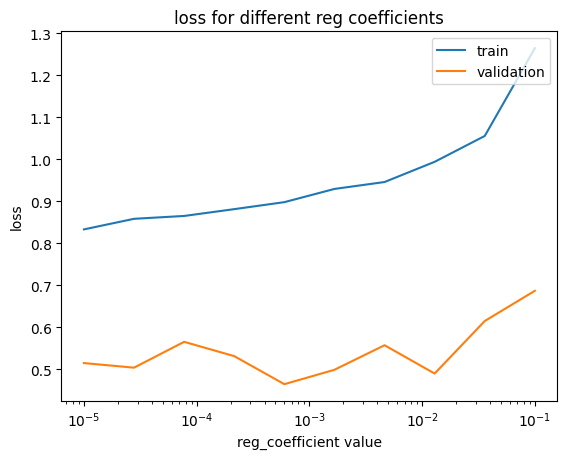

In [ ]:
plt.plot(regularization_params,loss_list)
plt.plot(regularization_params,val_loss_list)
plt.xscale('log')
plt.title('loss for different reg coefficients')
plt.ylabel('loss')
plt.xlabel('reg_coefficient value')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Extrañamente el conjunto de validación da mejores valores de la función de loss que el conjunto de aprendizaje. Sin embargo, se puede apreciar claramente una tendencia en entrenamiento ascendente (a empeorar) cuánto mayor es el coeficiente de regularización y por tanto más generaliza. En validación el loss fluctúa bastante pero se puede observar que para valores altos también empeora. Para los valores más bajos el loss en validación es relativamente bajo pero mejora para valores intermedios. Estos valores intermedios generalizan un poco más mejorando el rendimiento en validación sin empeorar demasiado el valor en entrenamiento evitando así overfitting y la excesiva generalización. Por esta razón vamos a elegir el coeficiente 0.0006.


<a name="metricas"></a>
## Métricas

Fijado el coeficiente de regularización, entrenamos el modelo con distintas proporciones del conjunto de entrenamiento para observar la curva de aprendizaje.

In [ ]:
number_layers, layer_1_u, layer_2_u, layer_3_u, layer_4_u, layer_1_a, layer_2_a, layer_3_a, layer_4_a, reg = best_hyperparams
reg = 0.0006
tam_train = [10, 50, 100, 200, 300, 500,700, 1000, 1500, 3000, 5000, 10000, 15000] 
loss_list = []
val_loss_list = []
f1score_list = []
val_f1score_list = []

# Entrenamos para diferentes tamaños del conjunto de entrenamiento
for tam in tam_train:
  print(tam)
  clear_session()
  tf.compat.v1.reset_default_graph()
  model = build_model(number_layers, layer_1_u, layer_2_u, layer_3_u, layer_4_u, layer_1_a, layer_2_a, layer_3_a, layer_4_a, reg)
  model.compile(optimizer='adam', loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.FalseNegatives(),f1_score])
  #early_stopping = EarlyStopping(monitor="val_f1_score",min_delta=0.001,patience=10,verbose=0,mode='max',restore_best_weights=True,)
  history = model.fit(X_train[:tam], y_train[:tam],validation_data=(X_valid, y_valid), class_weight = {0 : 1., 1 : 10.39}, batch_size=512, epochs=50, verbose=0, callbacks=[early_stopping])
  #best_epoch = early_stopping.best_epoch

  # Añadimos métricas en validación y entrenamiento a las listas para visualizarlas
  loss = history.history['loss'][-1]
  loss_list.append(loss)
  f1score = history.history['f1_score'][-1]
  f1score_list.append(f1score)
  val_loss = history.history['val_loss'][-1]
  val_loss_list.append(val_loss)
  val_f1score = history.history['val_f1_score'][-1]
  val_f1score_list.append(val_f1score)

10
50
100
200
300
500
700
1000
1500
3000
5000
10000
15000


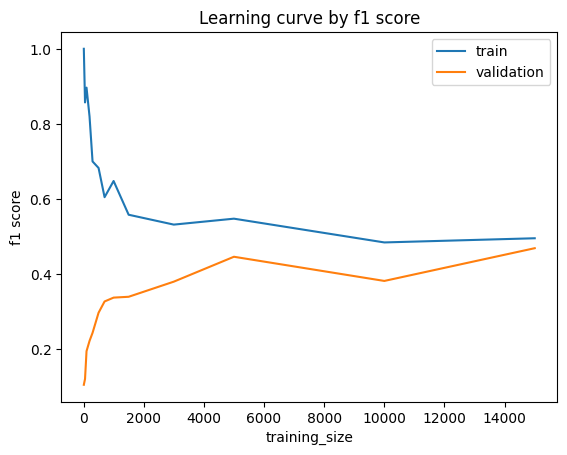

In [ ]:
  plt.plot(tam_train,f1score_list)
  plt.plot(tam_train,val_f1score_list)
  plt.title('Learning curve by f1 score')
  plt.ylabel('f1 score')
  plt.xlabel('training_size')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

La curva de aprendizaje para el f1 score tiene el aspecto típico aunque invertido (train por encima de validation) ya que en este caso intentamos maximizar el f1 score en vez de minizar el loss. Con pocos datos de entrenamiento, el modelo predice bien esas pocas instancias pero predice mal el conjunto de validación (sobreaprende). Para mayor tamaño del conjunto de entrenamiento el modelo tiene más datos y es capaz de generalizar más, por lo que se observa como sube la validación y baja la de entrenamiento. Para un tamaño del conjunto de entrenamiento mayor a 5000 se puede observar que el f1 score se estabiliza un poco aunque sigue mejorando para validación y empeorando para entrenemiento.

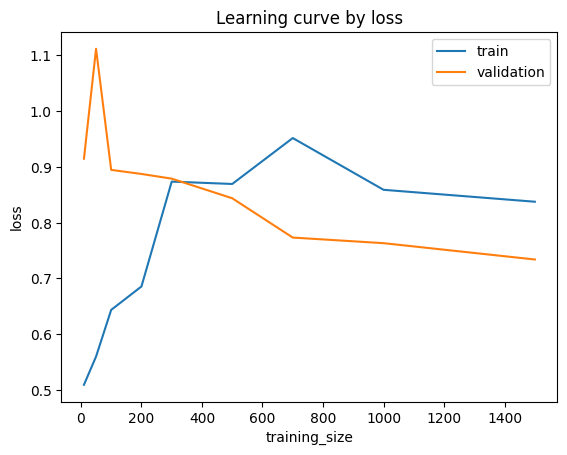

In [ ]:
  plt.plot(tam_train[:9],loss_list[:9])
  plt.plot(tam_train[:9],val_loss_list[:9])
  plt.title('Learning curve by loss')
  plt.ylabel('loss')
  plt.xlabel('training_size')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

La curva de aprendizaje para el loss podemos ver que comienza con una tendencia similar (aunque inversa porque ahora queremos minimizar). En este caso a partir de un tamaño de entrenamiento de 300 las gráficas se cruzan y posteriormente empiezan a decrecer (mejorar) a la vez.

Entrenamos una última vez el modelo sobre el conjunto de entrenamiento para observar las métricas principales en el conjunto de entrenamiento vs el conjunto de validación a lo largo de las epochs.

In [ ]:

model = build_model(number_layers, layer_1_u, layer_2_u, layer_3_u, layer_4_u, layer_1_a, layer_2_a, layer_3_a, layer_4_a, reg)

clear_session()
tf.compat.v1.reset_default_graph()
model.compile(optimizer='adam', loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.FalseNegatives(), f1_score])
early_stopping = EarlyStopping(monitor="val_f1_score",min_delta=0.001,patience=10,verbose=0,mode='max',restore_best_weights=True,)
history = model.fit(X_train, y_train,validation_data=(X_valid, y_valid), class_weight = {0 : 1., 1 : 10.39}, batch_size=256, epochs=50, verbose=0, callbacks=[early_stopping])

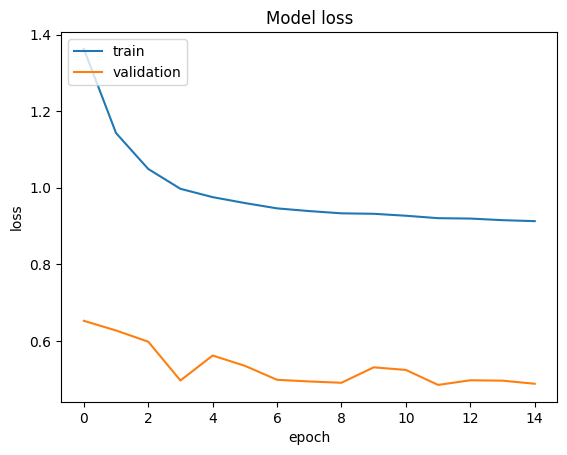

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Vemos, como es de esperar, que el loss en entrenamiento es constantemente decreciente aunque a partir de 5 epochs no mejora mucho. La validación sigue una tendencia menos clara aunque también decreciente.

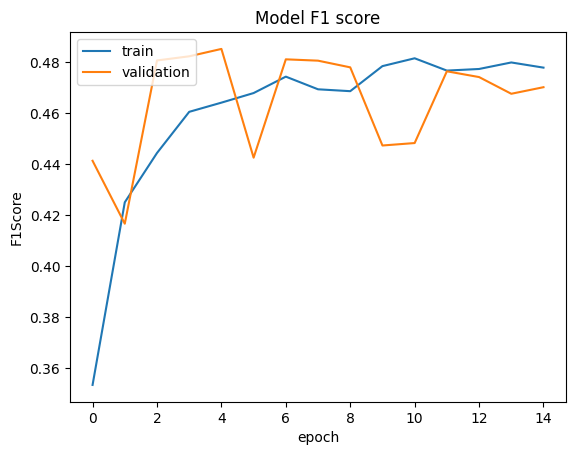

In [ ]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 score')
plt.ylabel('F1Score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

De la misma manera el f1 score en el conjunto de entrenamiento mejora (es mayoritariamente creciente) a lo largo de las epochs. Sin embargo, la métrica para el conjunto de validación mejora en las primeras epochs pero después fluctúa entre 0.45 y 0.49. 

Como estamos utilizando la técnica de early stopping, que deja de entrenar si el modelo no mejora en validación después de un número de epochs (y después recupera los valores de los pesos que han dado lugar a la mejor métrica en validación), podemos fijarnos en cuántas epochs entrena para establecerlo para nuestro modelo final.

In [ ]:
epochs = 15

<a name="eval"></a>
## Evaluación del modelo

Después de realizar todo lo anterior entrenamos el modelo en el conjunto de entrenamiento y validación para valorar su rendimiento con el conjunto de test y observar así su comportamiento.

In [ ]:
X_trainval = np.concatenate((X_train, X_valid), axis=0)
y_trainval = np.concatenate((y_train, y_valid), axis=0)

In [ ]:
def f1_score(y_true, y_pred):
    '''función para calcular métrica f1score del modelo
    obtenido de: 
    https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d'''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Entrenamiento sobre el conjunto de entrenamiento y validación
clear_session()
tf.compat.v1.reset_default_graph()
tic = time.time()
model = build_model(number_layers, layer_1_u, layer_2_u, layer_3_u, layer_4_u, layer_1_a, layer_2_a, layer_3_a, layer_4_a, reg)
model.compile(optimizer='adam', loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.FalseNegatives(), f1_score])
early_stopping = EarlyStopping(monitor="f1_score",min_delta=0.001,patience=10,verbose=0,mode='max',restore_best_weights=True,)
history = model.fit(X_trainval, y_trainval, class_weight = {0 : 1., 1 : 10.39}, batch_size=256, epochs=epochs, verbose=0, callbacks=[early_stopping])
toc = time.time()
t = toc - tic


In [ ]:
best_hyperparams =number_layers, layer_1_u, layer_2_u, layer_3_u, layer_4_u, layer_1_a, layer_2_a, layer_3_a, layer_4_a, reg

print("Best Hyperparameters:", best_hyperparams, '(los argumentos 32 y \'relu\' no se utilizan ya que la red solo tiene 3 capas)')
print(f'Tiempo de ejecución del entrenamiento {t}')

loss = history.history['loss'][-1]
accuracy = history.history['accuracy'][-1]
precision = history.history['precision'][-1]
recall = history.history['recall'][-1]
false_negatives = history.history['false_negatives'][-1]
f1score = history.history['f1_score'][-1]

print(f'TRAIN \nLoss: {loss} \nAccuracy: {accuracy} \nPrecision: {precision}\nRecall: {recall}\nFalse negatives: {false_negatives}\nF1Score: {f1score}')
metrics = model.evaluate(X_test, y_test)
loss = metrics[0]
accuracy = metrics[1]
precision = metrics[2]
recall = metrics[3]
false_negatives = metrics[4]
f1score = metrics[5]


print(f'TEST \nLoss: {loss} \nAccuracy: {accuracy} \nPrecision: {precision}\nRecall: {recall}\nFalse negatives: {false_negatives}\nF1Score: {f1score}')

Best Hyperparameters: (3, 1024, 512, 16, 32, 'relu', 'relu', 'relu', 'relu', 0.0006) (los argumentos 32 y 'relu' no se utilizan ya que la red solo tiene 3 capas)
Tiempo de ejecución del entrenamiento 87.38985443115234
TRAIN 
Loss: 0.9121357798576355 
Accuracy: 0.9015470147132874 
Precision: 0.44822174310684204
Recall: 0.5262511372566223
False negatives: 1543.0
F1Score: 0.48007097840309143
290/290 [==============================] - 1s 4ms/step - loss: 0.4884 - accuracy: 0.9034 - precision: 0.4545 - recall: 0.5037 - false_negatives: 404.0000 - f1_score: 0.4178
TEST 
Loss: 0.4884147047996521 
Accuracy: 0.9034066200256348 
Precision: 0.4545454680919647
Recall: 0.503685474395752
False negatives: 404.0
F1Score: 0.4178256392478943


Atendiendo a las métricas obtenidas con el conjunto de test podemos observar una clara mejoría con respecto al modelo de regresión. La red neuronal con la arquitectura indicada obtiene el mejor F1 score de los tres modelos, manteniendo un número de falsos negativos relativamente bajo. Sin embargo, en el modelo XGBClassiffier se observará que manteniendo un F1 score ligeramente más alto, el número de falsos negativos es menor. 

Visualicemos ahora la matriz de confusión:

290/290 [==============================] - 1s 5ms/step


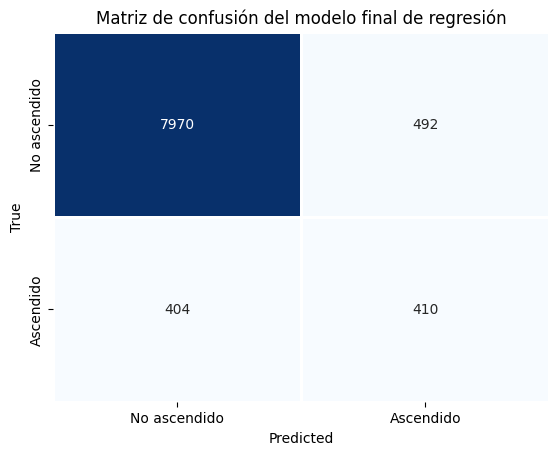

In [ ]:
y_predict = model.predict(X_test)
y_predict = y_predict > 0.5
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={'fontsize' : 10 }, linewidths=1, linecolor='white')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title('Matriz de confusión del modelo final de regresión')
    plt.show()

plot_confusion_matrix(y_test, y_predict, ['No ascendido','Ascendido'])

En la matriz de confusión de la red neuronal se puede apreciar como predice un número reducido de falsos negativos (predicted = NA y True = A) pero sin sacrificar los falsos positivos (predicted = A y True = NA) elevándolos demasiado, como sí hace el modelo XGBClassifier.

<a name="conclusion"></a>
# Conclusión

La arquitectura de red neuronal elegida funciona claramente mejor que la regresión para las métricas consideradas importantes. El número de false negatives de la predicción es de 404 prediciendo bien el 50% (recall) de los casos ascendidos. Esto lo hace a costa de predecir como ascendidos al 5,8% de los que no deberían serlo. En total recomienda para ascenso un total de 902 empleados, siendo correctas el 45,5% (precision) de las recomendaciones, es decir, casi la mitad de los recomendados para ser ascendidos lo han sido.

El modelo no tiene las métricas que serían deseables para poder ser utilizado. Sin embargo este modelo ofrece una buena aproximación ya que recupera la mitad de los empleados merecedores de ascenso sin recomendar demasiados de ellos no merecedores de él. Puede servir para hacer una criba y reducir el número de candidatos considerablemente aunque se dejaría fuera un número elevado de empleados merecedores del ascenso.

En el tercer y último modelo, XGBClassifier, se plantean algunas alternativas generales para mejorar el rendimiento de todos los modelos.

<a name="bib"></a>
# Bibliografía

- Apuntes de evaluación: https://cvmdp.ucm.es/moodle/mod/resource/view.php?id=2387418
- Apuntes de redes neuronales: https://cvmdp.ucm.es/moodle/mod/resource/view.php?id=2354114
- Apuntes de redes neuronales (2): https://cvmdp.ucm.es/moodle/mod/resource/view.php?id=2373209
- Documentación de métricas en keras: https://keras.io/api/metrics/
- Función métrica F1 Score: https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
- Práctica de redes neuronales: https://cvmdp.ucm.es/moodle/mod/resource/view.php?id=2402794